In [1]:
import torch
import math
import numpy as np
import xalglib
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Problem

## sklearn: LogisticRegression

In [2]:
X, y = load_breast_cancer(True)
X = (X - X.mean(axis=0)) / X.std(axis=0) + np.random.randn(*X.shape)
X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

In [3]:
log_reg = LogisticRegression(penalty='none', fit_intercept=False, solver='newton-cg', tol=1e-7)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=1e-07, verbose=0,
                   warm_start=False)

In [4]:
x_opt = log_reg.coef_[0]

In [5]:
x_opt

array([-0.79958168, -0.54571695, -0.51906312, -0.11792283, -0.02262045,
       -0.55188501, -0.1911352 , -0.4243348 ,  0.15537339,  0.18411131,
       -1.15803487, -0.00876188, -0.65974608, -0.40164107, -0.04764733,
       -0.33422752,  0.32886424, -0.18277646,  0.30442109,  0.89567177,
       -0.60535583, -0.72130665, -1.2434206 , -0.36327027, -0.61822979,
       -0.34115297, -0.25764687, -0.43840302, -0.78910538, -0.22289441,
        1.35780598])

In [6]:
log_reg.score(X, y)

0.9595782073813708

In [7]:
log_loss(y, log_reg.predict_proba(X))

0.12020288385500831

## PyTorch: optimization problem

In [8]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

x_opt = torch.tensor(x_opt, dtype=torch.float32)
N = x_opt.shape[0]

x_0 = torch.randn(N)

In [9]:
def f(x):
    return torch.nn.functional.binary_cross_entropy_with_logits(X @ x, y)

In [10]:
f(x_opt).item()

0.12020285427570343

In [11]:
f(x_0).item()

2.628032684326172

In [12]:
def check_optimality(f, x, step=1e-4, eps=1e-7):
    n = x.shape[0]
    fx = f(x)
    for i in range(n):
        for s in [-1, 1]:
            y = x.clone()
            y[i] += s * step
            fy = f(y)
            if fy < fx - eps:
                return False
    return True

In [13]:
check_optimality(f, x_0)

False

In [14]:
check_optimality(f, x_opt)

True

# Helper functions

In [62]:
def d_p(x, p):
    '''
    Prox-function
    '''
    return 1 / p * torch.norm(x)**p


def gradient(f, x, create_graph=False, retain_graph=None):
    '''
    Gradient of scalar function 'f' w.r.t. 1-d vector 'x'
    '''
    return torch.autograd.grad(
        outputs=[f],
        inputs=[x],
        create_graph=create_graph, 
        retain_graph=retain_graph)[0]


def hessian(f, x, create_graph=False):
    '''
    Hessian of scalar function 'f' w.r.t. 1-d vector 'x'
    '''
    n = x.shape[0]
    h = torch.empty(n, n)
    g = gradient(f, x, True)
    for i in range(n):
        h[i] = gradient(g[i], x, create_graph, True)
    return h


def D3(f, x, create_graph=False):
    n = x.shape[0]
    d3 = torch.empty(n, n, n)
    g = gradient(f, x, True)
    for i in range(n):
        d3[i] = hessian(g[i], x, create_graph)
    return d3


def hessian_vector_product(f, x, v, retain_graph=False):
    '''
    Hessian-vector product: D^2(f) @ v
    '''
    grad_f = gradient(f, x, True)
    return gradient(grad_f @ v, x, retain_graph=retain_graph)

In [37]:
def test():
    x = torch.tensor([1.5, 2.5], requires_grad=True)
    e = torch.tensor([1., 1.])
    f = x.pow(2).prod()
    print('F =', f, '\n')

    g = gradient(f, x, retain_graph=True)
    print('g =', g, '\n')

    h = hessian(f, x)
    print('h =', h, '\n')

    he = hessian_vector_product(f, x, e, retain_graph=True)
    print('h @ e =', he, '\n')
    
    d3 = D3(f, x)
    print('d3 =', d3, '\n')

test()

F = tensor(14.0625, grad_fn=<ProdBackward0>) 

g = tensor([18.7500, 11.2500]) 

h = tensor([[12.5000, 15.0000],
        [15.0000,  4.5000]]) 

h @ e = tensor([27.5000, 19.5000]) 

d3 = tensor([[[ 2.8610e-06,  1.0000e+01],
         [ 1.0000e+01,  6.0000e+00]],

        [[ 1.0000e+01,  6.0000e+00],
         [ 6.0000e+00, -1.4305e-06]]]) 



# Auxilary problem

In [38]:
def tridiag(d, e):
    '''
    Construct symmetric tridiagonal matrix from its main diagonal d and 
    above/below main diagonals equal to e
    '''
    return torch.diag(d) + torch.diag(e, -1) + torch.diag(e, 1)


def utu_decomposition(A):  # TODO
    '''
    Decomposition of symmetric matrix A to U @ T @ U.T, where
    U - symmetric ortogonal matrix, T - symmetric tridiagonla matrix
    '''
    a = A.tolist()
    N = len(a)
    a, tau, d, e = xalglib.smatrixtd(a, N, True)
    u = xalglib.smatrixtdunpackq(a, N, True, tau)
    U = torch.tensor(u)
    T = tridiag(torch.tensor(d), torch.tensor(e))
    return T, U


def auxilary_subproblem_objective(tau, T, c_tilda, gamma):
    I = torch.eye(len(c_tilda))
    value = tau**2 + .5 * c_tilda.T @ torch.inverse(2 * math.sqrt(gamma) * tau * I + T) @ c_tilda
    return value


def solve_auxilary_subproblem(T, c_tilda, gamma, learning_rate):
    tau = torch.tensor(1, dtype=torch.float32, requires_grad=True)
    for i in range(1000):  # TODO
        value = auxilary_subproblem_objective(tau, T, c_tilda, gamma)
        value.backward()
        with torch.no_grad():
            tau -= learning_rate * tau.grad
        tau.grad.detach_()
        tau.grad.zero_()
    return tau


def solve_auxilary_problem(A, c, gamma):
    T, U = utu_decomposition(A)
    c_tilda = U.T @ c

    tau = solve_auxilary_subproblem(T, c_tilda, gamma, 0.1)
    assert tau > 0
    I = torch.eye(len(c_tilda))
    h = -U @ torch.inverse(2 * math.sqrt(gamma) * tau * I + T) @ c_tilda
    
    return h

def auxilary_subproblem_dummy_objective(h, A, c, gamma):
    value = c @ h + .5 * h.T @ A @ h +  gamma * torch.norm(h)**4 / 4
    return value

def solve_auxilary_problem_dummy(A, c, gamma, learning_rate=0.001):
    h = torch.tensor([1, 1, 1, 1], dtype=torch.float32, requires_grad=True)
    for i in range(1000): 
        value = auxilary_subproblem_dummy_objective(h, A, c, gamma)
        value.backward()
        with torch.no_grad():
            h -= learning_rate * h.grad
        h.grad.detach_()
        h.grad.zero_()
    return h


In [39]:
def test():
    A = torch.tensor([
        [-1, -2, 1, 2],
        [-2, 3, 0, -2],
        [1, 0, 2, 1],
        [2, -2, 1, 4]
    ], dtype=torch.float32)
    c = torch.ones(4)
    gamma = 1

    T, U = utu_decomposition(A)
    print('A =', A, '\n')
    print('T =', T, '\n')
    print('U =', U, '\n')
    print('U @ T @ U.T =', U @ T @ U.T, '\n')

test()

A = tensor([[-1., -2.,  1.,  2.],
        [-2.,  3.,  0., -2.],
        [ 1.,  0.,  2.,  1.],
        [ 2., -2.,  1.,  4.]]) 

T = tensor([[ 1.9867,  0.9067,  0.0000,  0.0000],
        [ 0.9067, -1.3200, -1.6667,  0.0000],
        [ 0.0000, -1.6667,  3.3333, -3.0000],
        [ 0.0000,  0.0000, -3.0000,  4.0000]]) 

U = tensor([[ 0.1333, -0.7333, -0.6667,  0.0000],
        [-0.3333, -0.6667,  0.6667,  0.0000],
        [-0.9333,  0.1333, -0.3333,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]]) 

U @ T @ U.T = tensor([[-1.0000e+00, -2.0000e+00,  1.0000e+00,  2.0000e+00],
        [-2.0000e+00,  3.0000e+00,  8.1956e-08, -2.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  2.0000e+00,  1.0000e+00],
        [ 2.0000e+00, -2.0000e+00,  1.0000e+00,  4.0000e+00]]) 



A = tensor([[ 0.7467,  0.5064, -0.3284, -0.2032],
        [ 0.5064,  4.1816, -0.4006,  1.4852],
        [-0.3284, -0.4006,  1.4505,  0.0077],
        [-0.2032,  1.4852,  0.0077,  3.3837]]) 

T = tensor([[ 1.1302,  0.4556,  0.0000,  0.0000],
        [ 0.4556,  1.2698,  1.0151,  0.0000],
        [ 0.0000,  1.0151,  3.9788, -1.4991],
        [ 0.0000,  0.0000, -1.4991,  3.3837]]) 

U = tensor([[ 0.3572, -0.9242,  0.1355,  0.0000],
        [ 0.0440, -0.1283, -0.9908,  0.0000],
        [ 0.9330,  0.3598, -0.0051,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]]) 

U @ T @ U.T = tensor([[ 0.7467,  0.5064, -0.3284, -0.2032],
        [ 0.5064,  4.1816, -0.4006,  1.4852],
        [-0.3284, -0.4006,  1.4505,  0.0077],
        [-0.2032,  1.4852,  0.0077,  3.3837]]) 

tau = tensor(0.7850, requires_grad=True) 



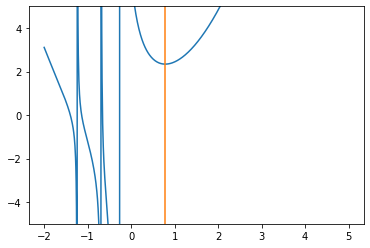

In [40]:
def test():
    c = torch.randn(4)
    x = torch.randn(4, requires_grad=True)
    f = -sum(torch.log(torch.sigmoid(x @ torch.randn(4))) for _ in range(10))
    A = hessian(f, x)
    gamma = 1

    T, U = utu_decomposition(A)
    print('A =', A, '\n')
    print('T =', T, '\n')
    print('U =', U, '\n')
    print('U @ T @ U.T =', U @ T @ U.T, '\n')

    tau = solve_auxilary_subproblem(T, c, gamma, 0.1)
    print('tau =', tau, '\n')

    xx = np.linspace(-2, 5, 1000)
    y = [auxilary_subproblem_objective(x, T, c, gamma) for x in xx]
    plt.plot(xx, y)
    plt.ylim(-5, 5)
    plt.plot([tau, tau], [-5, 5])

test()

A = tensor([[0.9407, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5929, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1349, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.6754]]) 

c = tensor([ 0.0000, 10.4709,  0.0000,  0.0000]) 

gamma = tensor([66.1202]) 

h = tensor([ 0.0000, -0.5355,  0.0000,  0.0000], grad_fn=<MvBackward>)


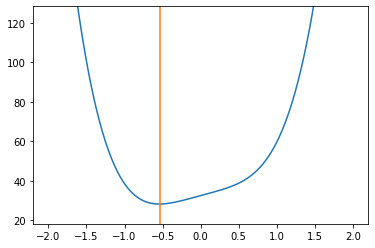

In [41]:
def test():
    A = torch.diag(torch.abs(torch.randn(4)))
    k = 1
    e_k = torch.zeros(4)
    e_k[k] = 1
    c = (10 + 10 * torch.abs(torch.randn(1))) * e_k
    gamma = 100 * torch.abs(torch.randn(1))

    print('A =', A, '\n')
    print('c =', c, '\n')
    print('gamma =', gamma, '\n')

    h = solve_auxilary_problem(A, c, gamma)
    print('h =', h)

    def f(h):
        return c @ h + .5 * c.T @ A @ c + gamma * torch.norm(h)**4 / 4

    xx = np.linspace(-2, 2, 1000)
    yy = [f(x * e_k) for x in xx]
    plt.plot(xx, yy)
    y1, y2 = min(yy) - 10, min(yy) + 100
    plt.ylim(y1, y2)
    plt.plot([h[k], h[k]], [y1, y2])

test()

A = tensor([[2.9651, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0539, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2919, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0596]]) 

c = tensor([ 0.0000, 20.1661,  0.0000,  0.0000]) 

gamma = tensor([119.1427]) 

h = tensor([ 5.4151e-18, -5.4783e-01,  8.7143e-17,  1.1090e-16],
       requires_grad=True)


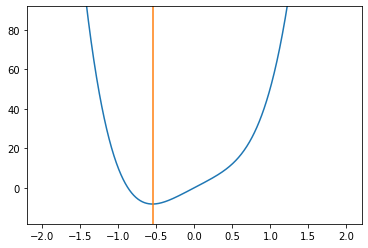

In [42]:
def test():
    A = torch.diag(torch.abs(torch.randn(4)))
    k = 1
    e_k = torch.zeros(4)
    e_k[k] = 1
    c = (10 + 10 * torch.abs(torch.randn(1))) * e_k
    gamma = 100 * torch.abs(torch.randn(1))

    print('A =', A, '\n')
    print('c =', c, '\n')
    print('gamma =', gamma, '\n')

    h = solve_auxilary_problem_dummy(A, c, gamma)
    print('h =', h)

    def f(h):
        return c @ h + .5 * h.T @ A @ h + gamma * torch.norm(h)**4 / 4

    xx = np.linspace(-2, 2, 1000)
    yy = [f(x * e_k) for x in xx]
    plt.plot(xx, yy)
    y1, y2 = min(yy) - 10, min(yy) + 100
    plt.ylim(y1, y2)
    plt.plot([h[k], h[k]], [y1, y2])

test()

# Bregman-distance gradient method

In [148]:
def BDGM(f, x_tilda_k, delta, L3):
    
    grad_f_x_tilda_k = torch.autograd.grad([f(x_tilda_k)], [x_tilda_k], create_graph=True)[0]
    
    z_0 = x_tilda_k
    tau = 3 * delta / (8 * (2 + math.sqrt(2)) * torch.norm(grad_f_x_tilda_k))
    
    def D2v(z):
        return hessian_vector_product(f(x_tilda_k), x_tilda_k, z - x_tilda_k)
    
    def rho_k(z):
        '''
        Scaling function
        '''
        return .5 * D2v(z) @ (z - x_tilda_k) \
               + L3 * d_p(z - x_tilda_k, 4)
    
    def beta_rho_k(z_i, z):
        '''
        Bregman distance
        '''
        grad_rho_k = torch.autograd.grad([rho_k(z_i)], [z_i], create_graph=True)[0]
        return rho_k(z) - rho_k(z_i) - grad_rho_k @ (z - z_i)
    
    def g_x_tilda_k_tau(z):
        x_p = x_tilda_k + tau * (z - x_tilda_k)
        grad_g_p = torch.autograd.grad([f(x_p)], [x_p], create_graph=True)[0]
        x_n = x_tilda_k - tau * (z - x_tilda_k)
        grad_g_n = torch.autograd.grad([f(x_n)], [x_n], create_graph=True)[0]
        return 1 / tau**2 * (grad_g_p + grad_g_n - 2 * grad_f_x_tilda_k)
    
    def g_phi_k_tau(z):
        return grad_f_x_tilda_k + D2v(z) + g_x_tilda_k_tau(z) + L3 * ((z - x_tilda_k)**2).sum() * (z - x_tilda_k)
    
    def auxilary_subproblem_dummy_objective(z, g_phi_k_tau_z_i, z_i): 
        value = g_phi_k_tau_z_i @ (z - z_i) + 2 * (1 + 2**(-.5))*beta_rho_k(z_i, z)
        return value
    
    def solve_auxilary_problem_dummy(g_phi_k_tau_z_i, z_i, learning_rate=0.001):
        z = torch.ones(len(z_i), dtype=torch.float32, requires_grad=True)
        for i in range(10000): 
            value = auxilary_subproblem_dummy_objective(z, g_phi_k_tau_z_i, z_i)
            value.backward(retain_graph=True)
#             print(value.item())
            with torch.no_grad():
                z -= learning_rate * z.grad
            z.grad.detach_()
            z.grad.zero_()
        return z
    
    i = 0
    z_i = z_0
    while True:
        g_phi_k_tau_z_i = g_phi_k_tau(z_i)
        print(i, z_i, torch.norm(g_phi_k_tau_z_i))
        grad_f_z_i = torch.autograd.grad([f(z_i)], [z_i], create_graph=True)[0]
        if torch.norm(g_phi_k_tau_z_i) <= 1 / 6 * torch.norm(grad_f_z_i) - delta:
            break
        else:
            z_i = solve_auxilary_problem_dummy(g_phi_k_tau_z_i, z_i, 0.0001)
        i += 1
    return z_i

In [137]:
x_tilda_k = torch.randn(4, requires_grad=True)

In [142]:
x_tilda_k

tensor([-0.8656,  0.1553, -0.4892, -0.5124], requires_grad=True)

In [149]:
def test():
    def f(x):
        return x.pow(4).sum()

    f_x_tilda_k = f(x_tilda_k)
    g = gradient(f_x_tilda_k, x_tilda_k, retain_graph=True)
    h = hessian(f_x_tilda_k, x_tilda_k)
    d3 = D3(f_x_tilda_k, x_tilda_k)
    
    print(g)
    print(h)
    print(d3)
    
    L3 = 5
    eps = 1e-2
    delta = eps**1.5 / (torch.norm(g)**0.5 + torch.norm(h)**1.5 / L3**0.5)
    
    def phi_k(z):
        y = z - x_tilda_k
        return g @ y + h @ y @ y + d3 @ y @ y @ y + L3 * torch.norm(y)**4 / 4

    def is_feasible(z):
        return torch.norm(z - x_tilda_k) <= 2 * ((2 + math.sqrt(2)) * torch.norm(g) / L3) ** (1/3)

    z_opt = BDGM(f, x_tilda_k, delta, L3)
    print('z_opt =', z_opt)
    print('z_opt is feasible:', is_feasible(z_opt))
    
    print('phi_k(z_opt) =', phi_k(z_opt))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-1))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-2))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-3))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-4))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-5))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-6))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-7))

test()

tensor([-2.5941,  0.0150, -0.4682, -0.5382])
tensor([[8.9908, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2896, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.8716, 0.0000],
        [0.0000, 0.0000, 0.0000, 3.1507]])
tensor([[[-20.7740,   0.0000,  -0.0000,  -0.0000],
         [ -0.0000,   0.0000,  -0.0000,  -0.0000],
         [ -0.0000,   0.0000,  -0.0000,  -0.0000],
         [ -0.0000,   0.0000,  -0.0000,  -0.0000]],

        [[ -0.0000,   0.0000,  -0.0000,  -0.0000],
         [ -0.0000,   3.7282,  -0.0000,  -0.0000],
         [ -0.0000,   0.0000,  -0.0000,  -0.0000],
         [ -0.0000,   0.0000,  -0.0000,  -0.0000]],

        [[ -0.0000,   0.0000,  -0.0000,  -0.0000],
         [ -0.0000,   0.0000,  -0.0000,  -0.0000],
         [ -0.0000,   0.0000, -11.7403,  -0.0000],
         [ -0.0000,   0.0000,  -0.0000,  -0.0000]],

        [[ -0.0000,   0.0000,  -0.0000,  -0.0000],
         [ -0.0000,   0.0000,  -0.0000,  -0.0000],
         [ -0.0000,   0.0000,  -0.0000,  -0.0000],
         [ -0.0

KeyboardInterrupt: 

# Hyperfast Second-Order Method

In [399]:
import numpy as np

def square_norm(x):
    return torch.sum(torch.tensor(x)**2)

def hyperfast_second_order_method(f, y_0, K, L3, delta):
    '''
    Algorithm 2: Hyperfast Second-Order Method
    '''
    A_0 = 0
    x_0 = y_0 
    x_tilda_k = x_0
    A_k = A_0
    x_k = x_0
    y_k = y_0
    for k in range(K):
        y_k_plus_1 = BDGM(f, x_tilda_k, delta, L3)
        y_k_plus_1.requires_grad_()
        lambda_min = 2 / (3 * L3 * square_norm(y_k_plus_1 - x_tilda_k))
        lambda_max = 1 / (L3 * square_norm(y_k_plus_1 - x_tilda_k))
        lambda_k_plus_1 = np.random.uniform(lambda_min, lambda_max)
        a_k_plus_1 = 1 / 2 * (lambda_k_plus_1 +
                              (lambda_k_plus_1 ** 2 +
                               4 * lambda_k_plus_1 * A_k) ** 0.5)
        A_k_plus_1 = a_k_plus_1 + A_k
        x_tilda_k = A_k * y_k / A_k_plus_1 + a_k_plus_1 * x_k / A_k_plus_1
        x_k = x_k - a_k_plus_1 * torch.autograd.grad([f(y_k_plus_1)],
                                                     [y_k_plus_1],
                                                     create_graph=True)[0]
        A_k = A_k_plus_1
        y_k = y_k_plus_1      
    return y_k